# Загрузка Pandas и очистка данных

In [661]:
import pandas as pd
from collections import Counter
import time
from datetime import datetime
import re

In [662]:
df = pd.read_csv('main_task.csv')

In [663]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [664]:
#Создаем столбец для пустных значений 'Number of Reviews', пропуски заполняем нолями
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
df['Number of Reviews'].fillna(0, inplace=True)

In [665]:
#Создаем толбец для пустых значений 'Price Range', пропуски заполняем самым часто встречающимся
df['Price Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
df['Price Range'] = df['Price Range'].fillna(df['Price Range'].mode()[0])

In [666]:
#Пропуски в ревью заполним пустыми строками
df['Reviews']=df['Reviews'].fillna('')

In [667]:
#Выше мы уже заполнили пропуски в 'Price Range' самым часто встречающимся значением
# Каждой категории цен присваиваем числовое значение
def new_price_range(row):
    if row['Price Range']=='$':
        return 1
    if row['Price Range']=='$$$$':
        return 3
    return 2

#Формируем новый столбец с категорией цен
df['New_PRange']=df.apply(lambda row: new_price_range(row), axis=1)

# Обрабатываем столбец 'Cuisine Style'

In [668]:
# Здесь работаем только с НЕпустыми значениями, чтобы в дальнейшем пропуски заполнить через fillna()
def replace_cuisine(x):
    if pd.isna(x):
        return x 
    else:
        replace_list = ['[',']',"'"]
        for value in replace_list:
            x = x.replace(value,'')
        return x.replace(', ',',')

df['Cuisine Style'] = df['Cuisine Style'].apply(replace_cuisine)

In [669]:
#Далее считаем, какое количество раз каждая кухня встречается в нашем датасете, для выявления самых популярных
max_count_cusine = Counter(df['Cuisine Style'].str.cat(sep=',').split(','))

In [670]:
# Сортируем полученный словарь
new_dc=dict(sorted(max_count_cusine.items(), key=lambda x: x[1], reverse=True))

In [671]:
#Выбираем 3 самых часто встречающихся типа кухонь
pop_cuis=', '.join(list(new_dc.keys())[:3])

In [672]:
# И заполняем ими пропуски
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: pop_cuis if pd.isna(x) else x)

In [673]:
#Функция по подстчету количества кухонь, представленных в каждом ресторане
def amount_of_cuisin(row):
    return len(row['Cuisine Style'].replace("'", '').split(','))

#Создаем новый числовой признак "количество кухонь"
df['cuisin_amount']=df.apply(lambda row: amount_of_cuisin(row), axis=1)

In [674]:
# считаем сколько ресторанов в каждом городе, формируем словарь
rest=dict(df.City.value_counts())

In [675]:
#функция отношения ранка ресторана к количеству ресторанов в городе 
def rest_rank(row, c_s):
    for i in c_s.keys():
        if row['City'] == i:
            res = row['Ranking']/c_s[i]
    return res

#Создаем новый признак - отношение ранка ресторана к количеству ресторанов по городу 
df['Rest_Rank'] = df.apply(lambda x: rest_rank(x, rest), axis=1)

# Работаем со столбцом 'Reviews'


In [676]:
# Переводим информацию из столбца ревью в формат даты
pattern = re.compile('\d+[/]\d+[/]\d+')
df['Reviews Date'] = df['Reviews'].apply(lambda x: pattern.findall(x))
df['Reviews Date'] = df['Reviews Date'].apply(lambda x: [pd.to_datetime(i).date() for i in x])

# Создаем новый признак - разница в днях между ревью

In [677]:
#Если у нас есть два ревью с датами, то считаем разницу, если дата одна или ее нет, то присваиваем 0
def review_date_diff(row):
    if len(row['Reviews Date'])==2:
        return abs((row['Reviews Date'][0]-row['Reviews Date'][1]).days)
    return 0
#Заполняем столбец с новым признаком
df['Delta_Review']=df.apply(lambda row: review_date_diff(row), axis=1)

In [678]:
#Переводим City в Dummy переменные
df=pd.get_dummies(df, columns = ['City'])

In [679]:
#Удаляем колонки с данными типа "object"
for col in df.columns:
    if(df[col].dtype)=='object':
        df.drop(columns=col, inplace=True)

In [680]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  40000 non-null  float64
 1   Rating                   40000 non-null  float64
 2   Number of Reviews        40000 non-null  float64
 3   Number_of_Reviews_isNAN  40000 non-null  uint8  
 4   Price Range_isNAN        40000 non-null  uint8  
 5   New_PRange               40000 non-null  int64  
 6   cuisin_amount            40000 non-null  int64  
 7   Rest_Rank                40000 non-null  float64
 8   Delta_Review             40000 non-null  int64  
 9   City_Amsterdam           40000 non-null  uint8  
 10  City_Athens              40000 non-null  uint8  
 11  City_Barcelona           40000 non-null  uint8  
 12  City_Berlin              40000 non-null  uint8  
 13  City_Bratislava          40000 non-null  uint8  
 14  City_Brussels         

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [681]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [682]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [683]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [684]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [685]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [686]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20907199999999998


<AxesSubplot:>

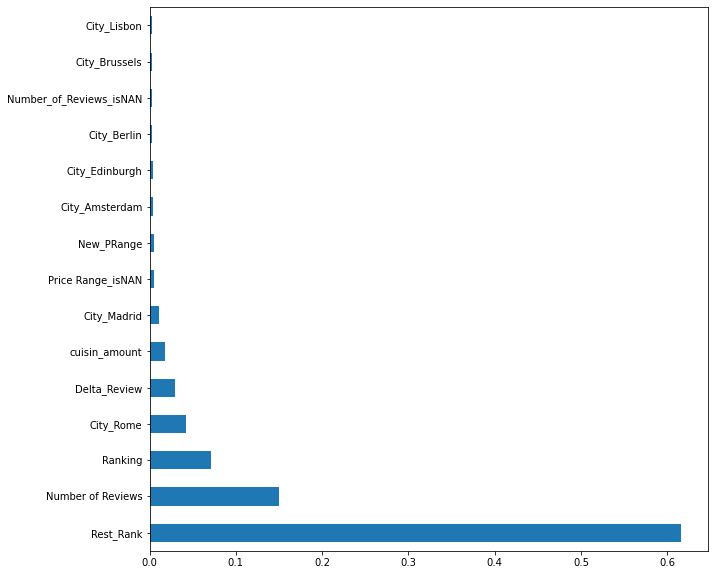

In [687]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')